In [71]:
""" Nice plotting utility to plot points given their                                                                                                                                                                                                                                      
    geographical coordinates,                                                                                                                                                                                                                                                             
    e.g. to localize observing stations """



import pandas as pd
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import os,sys
import os
import json
import xarray as xr
import numpy as np
import shapely
from shapely.geometry import Point, Polygon

import matplotlib.animation as animation

import geopandas as gpd
%matplotlib inline
%pylab inline


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)


out_dir = 'Plots/Stations_Locations'
os.system('mkdir  ' + out_dir )

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['Polygon', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


256

In [72]:
def loading_WMO_regions_gpd():
    """ Getting the WMO regions json file """
    WMO_json = 'WMO_regions.json'
    if not os.path.isfile(WMO_json):
        os.system( 'wget https://cpdb.wmo.int/js/json/WMO_regions.json --no-check-certificate ')

    WMO =  gpd.read_file('WMO_regions.json')
    return WMO

In [73]:
def get_WMO_region(WMO, lat, lon):
    """ Extract the WMO region code given lat and lon """
    geoPoint = Point(lon,lat)

    for wmo_code,row in WMO.iterrows():
            geom = row.geometry
            for g in geom:
                if geoPoint.within(g):
                    #print('Point ' , Point , ' is in region: ', wmo_code , ' ' , row.Region_en  )                                                                                                                                                                                        
                    return wmo_code , row.Region_en

In [74]:
def make_plot_gpd(WMO, results = ''):
    # https://stackoverflow.com/questions/59417997/how-to-plot-a-list-of-shapely-points                                                                                                                                                                                                   

    plt.xlim([-180.,180.])
    plt.ylim([-90.,90.])
    #clb=f.colorbar(c,ax=ax,orientation='horizontal')                                                                                                                                                                                                                                     
    #clb.ax.set_title('{:6.4f}'.format(np.mean(ds[k]).values/43200)+' '+units)                                                                                                                                                                                                            

    """ Loading from geopandas built-in methods """
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world = world.plot()

    dates = { 0:  { 'min': '1900-01-01' , 'max': '1920-01-01' } , 
                     1: { 'min': '1920-01-01'  , 'max': '1940-01-01' } ,
                     2: { 'min': '1940-01-01'  , 'max': '1960-01-01' } ,
                     3: { 'min': '1960-01-01'  , 'max': '1980-01-01' } ,
                     4: { 'min': '1980-01-01'  , 'max': '2000-01-01' } ,
                     5: { 'min': '2000-01-01'  , 'max': '2020-01-01' } ,     }
    
    style_dic = { 1 : { 'c' : 'navy'         ,           'l': 'Africa'} , 
                          2 : { 'c' : 'lime'         ,           'l': 'Asia' } ,
                          3 : { 'c' : 'red'           ,           'l': 'South America' } ,
                          4 : { 'c' : 'gold'         ,           'l': 'North America, Central America, Caribbean' } ,
                          5 : { 'c' : 'magenta'  ,           'l': 'South-West Pacific' } ,
                          6 : { 'c' : 'cyan'        ,            'l': 'Europe' }  }

    for d in dates:
        
        #f=plt.figure(figsize=(15,13))
        #ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
        
        #f=plt.figure(figsize=(15,13))
        #f.add_subplot(121,projection=ccrs.PlateCarree())
            
        plt.xlim([-180.,180.])
        plt.ylim([-90.,90.])
        #clb=f.colorbar(c,ax=ax,orientation='horizontal')                                                                                                                                                                                                                                     
        #clb.ax.set_title('{:6.4f}'.format(np.mean(ds[k]).values/43200)+' '+units)                                                                                                                                                                                                            
    
        """ Loading from geopandas built-in methods """
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        world = world.plot()
        WMO.plot( ax=world,  facecolor="none", edgecolor="lightgray", lw = 0.8)

        
        wmo_regions_dic = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0} 
        
        start_date_string = dates[d]['min'] 
        end_date_string = dates[d]['max'] 
        
        date_min  = np.datetime64(dates[d]['min'])
        date_max = np.datetime64(dates[d]['max'])

        """ I store here the lat, lon and record corunts for each station """
        
        points_lat, points_lon, points_size = [] , [] , [] 
        
        skipped = 0

        
        for station in results:
            if not station:
                continue
            
            if station[d] > 0:
                try:
                    lat = station['lat']
                    lon = station['lon']
                except:
                    print('No lat lon for  ', station )
                    skipped += 1 
                    continue
                
                if lon > 180:  # fix ncar longitude [0,360] while geopandas wants [-180,+180]
                    lon = lon - 360 
        
                try:
                    wmo_code , row_region = get_WMO_region (WMO, lat, lon)
                except:
                    #print('Skipping ', station )
                    skipped += 1                 
                    pass 
            
                points_lat.append(lat)
                points_lon.append(lon)
                points_size.append(station[d])
                         
                #wmo_regions_dic[wmo_code] += 1 
            
        if len(points_lat) == 0:
            points_lat.append(-999)
        if len(points_lon) == 0:
            points_lon.append(-999)


        plotto = plt.scatter( points_lon, points_lat , c= points_size,  s = 0.7, cmap='rainbow' )
        cbar = plt.colorbar(fraction=0.03, pad=0.03) # pad moves bar to left-right, fractions is the length of the bar
        cbar.set_label('Number of Records ')

        plt.title ('Active Radiosondes between '  + start_date_string + ' and ' + end_date_string , fontsize = 9)

        plt.xlim([-180.,180.])
        plt.ylim([-90.,90.])

        #plt.legend(loc = 'lower left', fontsize = 6 ,ncol = 2)
        plt.savefig(out_dir + '/Map_shapely_' + start_date_string + '.png', dpi= 250,   bbox_inches = 'tight' )
        plt.show()
        #plt.close()
        print('Done +++' , d )



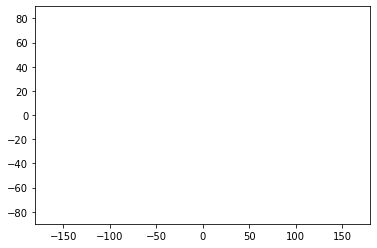

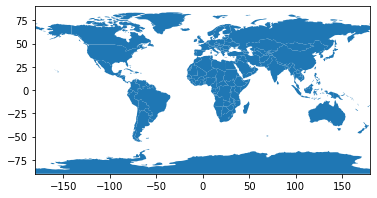

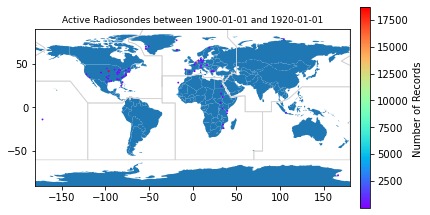

Done +++ 0


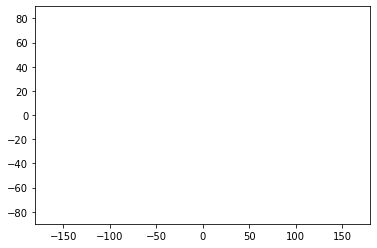

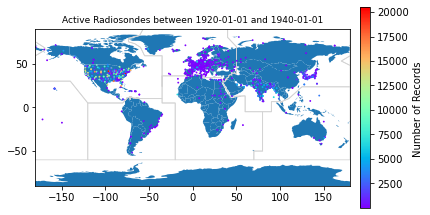

Done +++ 1


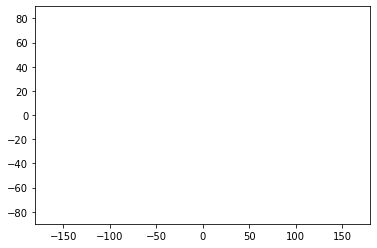

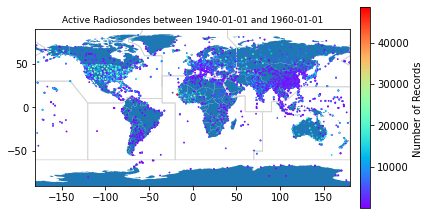

Done +++ 2


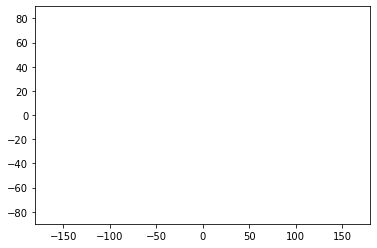

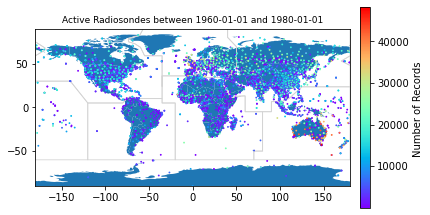

Done +++ 3


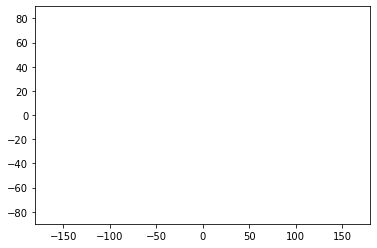

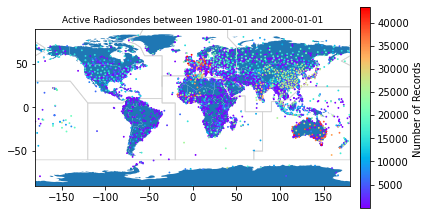

Done +++ 4


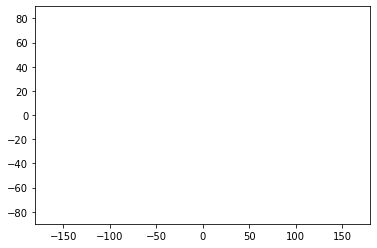

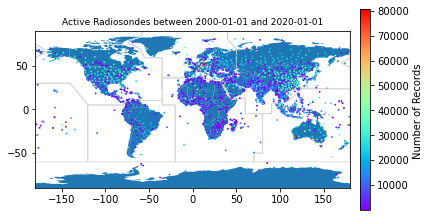

Done +++ 5


In [77]:
""" Running """

out_dir = 'Plots/Station_Location/'
os.system('mkdir  ' + out_dir )
    
load_data = np.load('Record_counts_merged_file.npy', allow_pickle= True)
    
WMO =  loading_WMO_regions_gpd()

plotto = make_plot_gpd(WMO, results = load_data )        